# Clustering
We will:<br>
- Filter our race df to get the fastest lap time per race<br>
- Calculate the track length<br>
- Use the track length and velocity to cluster the races into clusters<br>
- Create a new feature for our next ML model<br>

In [1]:
import pandas as pd
import seaborn as sns

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
#As always, we need to load our data (file name: race_df_with_advanced_features.pkl):
race_df = pd.read_pickle('race_df_with_advanced_features.pkl')
race_df.head(5)

qgrid_pos  Nr.       Driver      Team  fp2_pos     fp2_t  fp3_pos  \
0          3    8    F. Alonso   Ferrari      9.0  117140.0      1.0   
1          2    7     F. Massa   Ferrari      7.0  116555.0      6.0   
2          4    2  L. Hamilton   McLaren      2.0  115854.0     12.0   
3          1    5    S. Vettel  Red Bull      5.0  116459.0      5.0   
4          5    4   N. Rosberg  Mercedes      1.0  115409.0      2.0   

      fp3_t  fp1_pos     fp1_t  ...  hist_fp2_pos  hist_fp3_pos  hist_fp1_pos  \
0  114099.0      2.0  116766.0  ...           NaN           NaN           NaN   
1  114739.0      4.0  117055.0  ...           NaN           NaN           NaN   
2  115860.0      6.0  117163.0  ...           NaN           NaN           NaN   
3  114646.0     13.0  117943.0  ...           NaN           NaN           NaN   
4  114368.0      8.0  117199.0  ...           NaN           NaN           NaN   

   hist_q_pos  hist_race_pos  best_fp_pos  worst_fp_pos mean_fp_pos  \
0         NaN            NaN          1.0           3.0         2.0   
1         NaN            NaN          6.0           1.0         5.0   
2         NaN            NaN         12.0           4.0         6.0   
3         NaN            NaN          5.0          10.0         7.0   
4         NaN            NaN          2.0           5.0         1.0   

   r_hist_qgrid_pos_2_fp  r_hist_race_pos_2_fp  
0                    NaN                   NaN  
1                    NaN                   NaN  
2                    NaN                   NaN  
3                    NaN                   NaN  
4                    NaN                   NaN  

[5 rows x 50 columns]

## Filter the df
To calculate the track length, we will use <i>best_fp_t</i> as time per race and the velocity (v_m_s).<br>
By multiplying the two, we have a metric for the length (it is not accurate, because the time is from free practice, while the velocity is from the race).

In [3]:
#To keep our life a bit easy we will drop columns from race_df where we have NaNs in best_fp_t or v_m_s
print(race_df.shape)
race_df = race_df.dropna(subset=['best_fp_t','v_m_s']).reset_index(drop=True)
print(race_df.shape)

#Filter race_df to have the fastest time per race:
min_indx_mask = race_df.groupby("race_name")['best_fp_t'].idxmin()
min_indx_mask
track_df = race_df.iloc[min_indx_mask][['race_name','best_fp_t','v_m_s']]
track_df

(4718, 50)
(3890, 50)


race_name  best_fp_t      v_m_s
3753                   grosser-preis-der-eifel    86361.0  53.721667
3786          grosser-preis-der-emilia-romagna    74726.0  58.174722
3601              grosser-preis-der-steiermark    63660.0  61.236667
3724                 grosser-preis-der-toskana    76530.0  36.933056
461                  grosser-preis-der-tuerkei    86037.0  57.110000
3531                     grosser-preis-der-usa    93232.0  54.683611
3653  grosser-preis-des-70jaehrigen-jubilaeums    85606.0  63.880278
3853               grosser-preis-von-abu-dhabi    96251.0  52.750556
3272           grosser-preis-von-aserbaidschan   101604.0  54.827222
3218              grosser-preis-von-australien    82292.0  59.743889
3819                 grosser-preis-von-bahrain    88355.0  28.570278
3069                 grosser-preis-von-belgien   102661.0  61.432500
3189               grosser-preis-von-brasilien    67948.0  58.195556
3251                   grosser-preis-von-china    92830.0  55.136667
3395             grosser-preis-von-deutschland    72548.0  46.678889
543                   grosser-preis-von-europa    97258.0  51.685833
3340              grosser-preis-von-frankreich    90159.0  60.851667
3645         grosser-preis-von-grossbritannien    85873.0  57.518611
725                   grosser-preis-von-indien    84824.0  56.710278
3711                 grosser-preis-von-italien    80089.0  47.678056
3495                   grosser-preis-von-japan    87785.0  61.479444
3322                  grosser-preis-von-kanada    70843.0  57.051944
2779                grosser-preis-von-malaysia    91261.0  57.074444
3515                  grosser-preis-von-mexiko    76145.0  52.508889
3302                  grosser-preis-von-monaco    71118.0  41.924444
3359             grosser-preis-von-oesterreich    63987.0  62.229444
3768                grosser-preis-von-portugal    76654.0  56.584722
3482                grosser-preis-von-russland    92733.0  55.073611
3843                  grosser-preis-von-sachir    54270.0  56.095833
3102                grosser-preis-von-singapur    98054.0  45.996111
3284                 grosser-preis-von-spanien    76568.0  53.405278
707                grosser-preis-von-suedkorea    96910.0  52.339444
3618                  grosser-preis-von-ungarn    75437.0  53.032500

In [4]:
#Now we can calculate the track length (v[m/s] * t[s])
track_df['length'] = track_df['v_m_s'] * track_df['best_fp_t'] / 1000
track_df.head(5)

race_name  best_fp_t      v_m_s       length
3753           grosser-preis-der-eifel    86361.0  53.721667  4639.456855
3786  grosser-preis-der-emilia-romagna    74726.0  58.174722  4347.164293
3601      grosser-preis-der-steiermark    63660.0  61.236667  3898.326200
3724         grosser-preis-der-toskana    76530.0  36.933056  2826.486742
461          grosser-preis-der-tuerkei    86037.0  57.110000  4913.573070

## Clustering
Based on the features <i>v_m_s</i> and <i>length</i>, we want to see if we can cluster the tracks into certain types.<br>
Are there maybe short fast and long slow tracks?

First we need to scale our data. For good clustering, the ranges of the values per feature should be in the same magnitude. scikit-learn provides various scalers:<br>
https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py

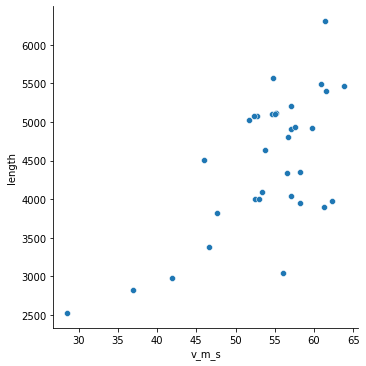

In [5]:
#First, create a scatter plot of our two features:
sns.relplot(data=track_df,x='v_m_s',y='length')

In [6]:
#Now chose a scaler and scale the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer


track_df_scaled = track_df.copy()
#Scale the data:
track_df_scaled[['v_m_s','length']] = RobustScaler().fit_transform(track_df_scaled[['v_m_s','length']])
track_df_scaled.head()

race_name  best_fp_t     v_m_s    length
3753           grosser-preis-der-eifel    86361.0 -0.249743  0.000000
3786  grosser-preis-der-emilia-romagna    74726.0  0.536206 -0.261820
3601      grosser-preis-der-steiermark    63660.0  1.076629 -0.663865
3724         grosser-preis-der-toskana    76530.0 -3.212874 -1.623962
461          grosser-preis-der-tuerkei    86037.0  0.348287  0.245539

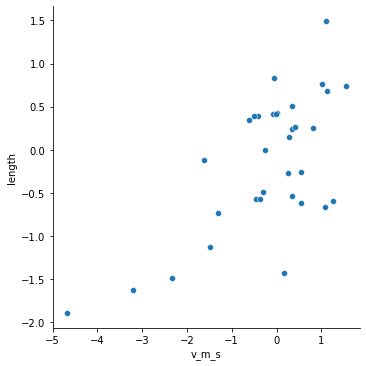

In [7]:
#Plot the scaled data:
sns.relplot(data=track_df_scaled,x='v_m_s',y='length')

Depending on our scaler, the plot might look the same.<br>
If so, have a closer look at the value ranges.

## Now we can cluster the data:
Today, we will simply use k-means clustering

In [8]:
from sklearn.cluster import KMeans
from sklearn import metrics

In [9]:
X = track_df_scaled[['v_m_s','length']]
kmeans_model = KMeans(n_clusters=4, random_state=1).fit(X)
labels = kmeans_model.labels_
metrics.silhouette_score(X, labels, metric='euclidean')

0.3573790733338849

Ok, now we have a number, that evaluates our model.<br>
We went for four clusters. Was this a good idea?<br>
Lets plot the data and color by label:

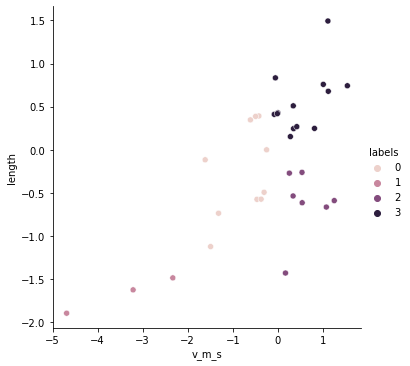

In [10]:
#Add the labels to our data and create a plot:
track_df_scaled['labels'] = labels
sns.relplot(data=track_df_scaled,x='v_m_s',y='length',hue='labels')

### Find a good number of clusters
Similar to an earlier exercise, run a loop and vary the number of clusters.
Record the results, plot them and chose a number of clusters of your choise based on that.

In [11]:
#Initialize a df to keep track of the results
accuracy_df = pd.DataFrame({'n_clusters':[],'score':[]})
#Run a loop t try differnt cluster numbers
for n_clusters in range(2, 12):
    kmeans_model = KMeans(n_clusters=n_clusters, random_state=1).fit(X)
    labels = kmeans_model.labels_
    score = metrics.silhouette_score(X, labels, metric='euclidean')
    
    accuracy_df = accuracy_df.append({'n_clusters':n_clusters,
                                      'score':score},
                                       ignore_index=True)
    
accuracy_df

n_clusters     score
0         2.0  0.587380
1         3.0  0.350443
2         4.0  0.357379
3         5.0  0.414911
4         6.0  0.437170
5         7.0  0.405691
6         8.0  0.396373
7         9.0  0.428972
8        10.0  0.460914
9        11.0  0.450835

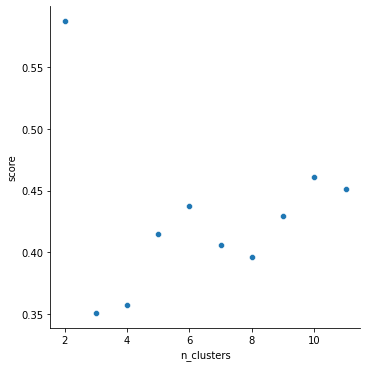

In [12]:
#Plot the results:
sns.relplot(data=accuracy_df,x='n_clusters',y='score')

There are so few data point in our set, which makes this plot look a bit strange.<br>
We can pick either 3 or 4 clusters.

### Calculate the final clusters
 - Pick either 3 or 4 clusters
 - calculate the labels
 - Attach them to the small df
 - Export the new df to csv

In [13]:
#Calculate the new labels:
X = track_df_scaled[['v_m_s','length']]
kmeans_model = KMeans(n_clusters=4, random_state=1).fit(X)
labels = kmeans_model.labels_
metrics.silhouette_score(X, labels, metric='euclidean')

0.3573790733338849

In [14]:
#Attach the labels to the df:
track_df_scaled['labels'] = labels

In [15]:
#Export to csv:
track_df_scaled.to_csv('labeled_tracks.csv',sep=';')

## If you have time left over:
Copy-pasting code around is never a good idea.<br>
Here we calculated the clusters twice and also many times in our loop.<br>
- Copy the notebook to a new name (<i>File -> Make a Copy...</i>)
- Rewrite the notebook by writing a clustering function on top and call it where neccassary